# Import Data & EDA

In [1]:
# 安装kaggle - pip install kaggle

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
print('写入kaggle.json中API的用户名和密码')
# kaggle API username & key
creds = '{"username":"yming2cn","key":"53c11dfdaff9c9e63ca5efe57f46b3d9"}' 

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
cred_path.parent.mkdir(exist_ok=True)
cred_path.write_text(creds)
cred_path.chmod(0o600)
print('写入成功')
    

写入kaggle.json中API的用户名和密码
写入成功


In [2]:
import kaggle # kaggle需要API keys
# 直接import kaggle会发生OS Error：Could not find kaggle.json.


In [3]:
# Now you can download datasets from Kaggle.
path = Path('us-patent-phrase-to-phrase-matching')

In [4]:
# And use the Kaggle API to download the dataset to that path, and extract it:
import zipfile,kaggle
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

us-patent-phrase-to-phrase-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls {path}
# It looks like this competition uses CSV files. For opening, manipulating, and viewing CSV files, 
# it's generally best to use the Pandas library, 
# which is explained brilliantly in this book by the lead developer 
# (it's also an excellent introduction to matplotlib and numpy, both of which I use in this notebook). 
# Generally it's imported as the abbreviation pd.

sample_submission.csv test.csv              train.csv


In [6]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [7]:
df.describe(include='object')
# We can see that in the 36473 rows, there are 733 unique anchors, 106 contexts, and nearly 30000 targets. 
# Some anchors are very common, with "component composite coating" for instance appearing 152 times.

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


Earlier, I suggested we could represent the input to the model as something like "TEXT1: abatement; TEXT2: eliminating process". We'll need to add the context to this too. In Pandas, we just use + to concatenate, like so:

In [8]:
# represent the input to the model as: "TEXT1: abatement; TEXT2: eliminating process"
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.head()

,id,anchor,target,context,score,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,TEXT1: A47; TEXT2: abatement of pollution; ANC...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,TEXT1: A47; TEXT2: forest region; ANC1: abatement


In [9]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

# Tokenization

In [10]:
from datasets import Dataset,DatasetDict 
# datasets是huggingface的一个包， one-line dataloaders for many public datasets

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [11]:
model_nm = 'microsoft/deberta-v3-small'

In [14]:
# AutoTokenizer will create a tokenizer appropriate for a given model:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")
print(tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/yiming/Anaconda/anaconda3/envs/tch/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['▁G', "'", 'day', '▁folks', ',', '▁I', "'", 'm', '▁Jeremy', '▁from', '▁fast', '.', 'ai', '!']


In [15]:
# Uncommon words will be split into pieces. The start of a new word is represented by ▁:
print(tokz.tokenize("A platypus is an ornithorhynchus anatinus."))

['▁A', '▁platypus', '▁is', '▁an', '▁or', 'ni', 'tho', 'rhynch', 'us', '▁an', 'at', 'inus', '.']


In [16]:
def tok_func(x): 
    return tokz(x["input"])

In [19]:
# To run this quickly in parallel on every row in our dataset, use map:
tok_ds = ds.map(tok_func, batched=True)
tok_ds

  0%|          | 0/37 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [20]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

So, what are those IDs and where do they come from? The secret is that there's a list called vocab in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of": 例如找到单词“of”的token：

In [21]:
tokz.vocab['▁of']

265

In [24]:
print(tok_ds)

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})


Looking above at our input IDs, we do indeed see that 265 appears as expected.在上面查看我们的输入 ID，我们确实看到 265 按预期出现。


Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

最后，我们需要准备我们的token标签。 Transformers 始终假定您的标签具有列名称标签，但在我们的数据集中，它当前是得分。 因此，我们需要重命名它:

In [25]:
tok_ds = tok_ds.rename_columns({'score':'labels'}) # 把score改成了label
print(tok_ds) 

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})


# Test Set Vs. Validation Set

In [26]:
# eval_df - evaluation dataframe
eval_df = pd.read_csv(path/'test.csv') 
eval_df.describe()


,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


This is the test set. Possibly the most important idea in machine learning is that of **having separate training, validation, and test data sets.**

### Validation set

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [28]:
def f(x): 
    return -3*x**2 + 2*x + 20

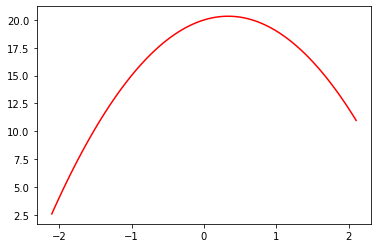

In [30]:
# 手动visualize function 
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

plot_function(f)

For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use seed when writing about simulations like this so that I know you'll see the same thing I do:

In [31]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [34]:
def noise(x, scale): 
    return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): 
    return x * (1+noise(x,mult)) + noise(x,add)

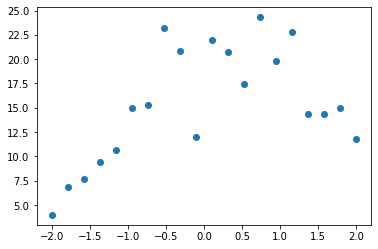

In [36]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we underfit or overfit these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like! (PS: if you're not sure about the jargon around polynomials, here's a great video which teaches you what you'll need to know.)

现在让我们看看如果我们欠拟合或过拟合这些预测会发生什么。 为此，我们将创建一个适合某种程度的多项式的函数（例如，一条线是 1 次，二次是 2 次，三次是 3 次等）。 这个函数如何工作的细节并不重要，所以如果你愿意，可以跳过它！ （PS：如果你不确定多项式的术语，这里有一个很棒的视频，它教你需要知道什么。）

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

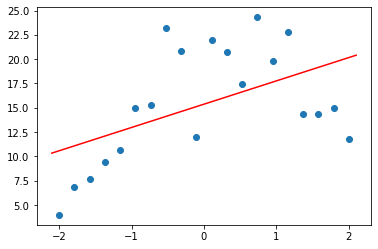

In [38]:
# Under-fit example
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is under-fit -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

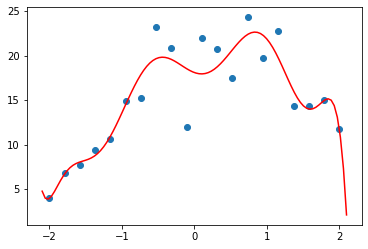

In [39]:
# Overfit example
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is over-fit -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

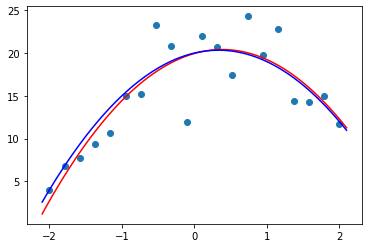

In [40]:
# 一个不错的拟合，2次就够了
plot_poly(2)
plot_function(f, color='b')

还不错！

那么，我们如何识别我们的模型是欠拟合、过拟合还是“恰到好处”呢？ 我们使用验证集。 这是我们从训练中“保留”下来的一组数据——我们根本不让我们的模型看到它。 如果您使用 fastai 库，如果您没有验证集，它会自动为您创建一个验证集，并且始终使用验证集报告指标（模型准确性的测量值）。

验证集仅用于查看我们的表现。 它从未用作训练模型的输入。

Transformers 使用 DatasetDict 来保存您的训练和验证集。 要创建一个包含 25% 的验证集数据和 75% 的训练集数据，请使用 train_test_split：

In [43]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

As you see above, the validation set here is called test and not validate, so be careful!

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

"One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a train_test_split method, this method takes a random subset of the data, which is a poor choice for many real-world problems."

I strongly recommend reading her article How (and why) to create a good validation set to more fully understand this critical topic.

用scikit learn 自带的方法随机分割训练集和测试集 可能不总是一个好主意, 要根据问题的实际情况。例如预测性的时间序列数据项目，应该取最接近现在的数据做测试集


### Test set
So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The test set is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc. 

测试集是另一个从训练中提取出来的数据集。但它也被排除在报告指标之外！只有在您完成整个训练过程（包括尝试不同的模型、训练方法、数据处理等）后，才会检查您的模型在测试集上的准确性。

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set! 您会看到，当您尝试所有这些不同的事情时，为了查看它们对验证集指标的影响，您可能只是偶然发现了一些完全巧合地改善了您的验证集指标的事情，但在实践中并没有真正更好。如果有足够的时间和实验，你会发现很多这些巧合的改进。这意味着您实际上过度拟合了您的验证集！

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set! 这就是我们保留测试集的原因。 Kaggle 的公开排行榜就像一个测试集，你可以不时查看。但是不要太频繁地检查，否则你甚至会过度拟合测试集！

Kaggle has a second test set, which is yet another held-out dataset that's only used at the end of the competition to assess your predictions. That's called the "private leaderboard". Here's a great post about what can happen if you overfit to the public leaderboard.

We'll use eval as our name for the test set, to avoid confusion with the test dataset that was created above.

我们将使用 eval 作为test set 的名称，以避免与上面创建的测试数据集混淆。

In [44]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Metrics and correlation
When we're training a model, there will be one or more metrics that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.

当我们训练一个模型时，会有一个或多个我们对最大化或最小化感兴趣的指标。 希望这些测量值能够代表我们的模型对我们的效果。

In [45]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [46]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [47]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

create this little function to just return the single number we need given a pair of variables:

In [48]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906004

看房子数据集中各个feature之间的correlation

In [49]:
# a few exmaples of correlations 
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

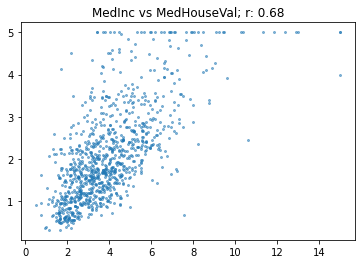

In [51]:
show_corr(housing, 'MedInc', 'MedHouseVal')

So that's what a correlation of 0.68 looks like. It's quite a close relationship, but there's still a lot of variation. (Incidentally, this also shows why looking at your data is so important -- we can see clearly in this plot that house prices above $500,000 seem to have been truncated to that maximum value).

这就是 0.68 的相关性。 这是一个非常密切的关系，但仍然有很多变化。 （顺便说一句，这也说明了为什么查看您的数据如此重要——我们可以在该图中清楚地看到，高于 500,000 美元的房价似乎已被截断为该最大值）。

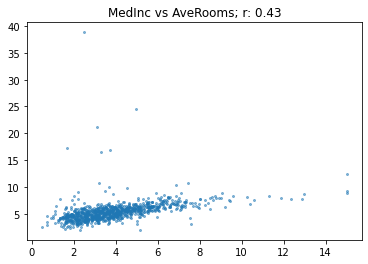

In [52]:
show_corr(housing, 'MedInc', 'AveRooms')

The relationship looks like it is similarly close to the previous example, but r is much lower than the income vs valuation case. Why is that? The reason is that there are a lot of outliers -- values of AveRooms well outside the mean. 

该关系看起来与前面的示例类似，但 R 远低于收入与估值的情况。 这是为什么？ 原因是有很多异常值——AveRooms 的值远远超出平均值。

r is very sensitive to outliers. If there's outliers in your data, then the relationship between them will dominate the metric. In this case, the houses with a very high number of rooms don't tend to be that valuable, so it's decreasing r from where it would otherwise be. \
R 对异常值非常敏感。 如果您的数据中存在异常值，那么它们之间的关系将主导指标。 在这种情况下，房间数量非常多的房子往往不会那么有价值，所以它会从原本的位置减少 r。

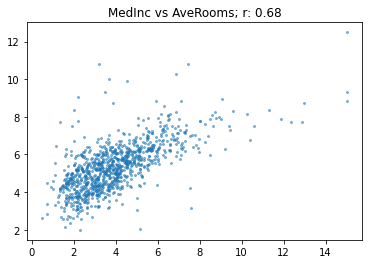

In [53]:
# after remove outliers:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

As we expected, now the correlation is very similar to our first comparison.

Here's another relationship using AveRooms on the subset:

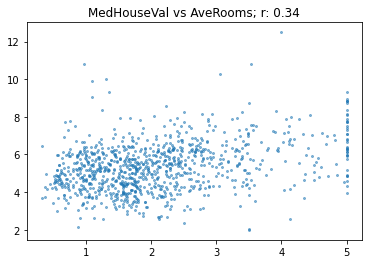

In [54]:
show_corr(subset, 'MedHouseVal', 'AveRooms')


with r of 0.34, the relationship is becoming quite weak.

In [55]:
def corr_d(eval_pred): 
    return {'pearson': corr(*eval_pred)}

# Training

In [57]:
from transformers import TrainingArguments,Trainer
bs = 128  # batch size
epochs = 4  # nums of epochs

The most important hyperparameter is the **learning rate**. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

In [58]:
lr = 8e-5

Transformers uses the **TrainingArguments** class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.\
Transformers 使用 TrainingArguments 类来设置参数。 不要太担心我们在这里使用的值——它们通常在大多数情况下都可以正常工作。 您可能需要针对不同的模型更改上述 3 个参数。

In [60]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')
# removed fp16=True, for solving "FP16 Mixed precision training with AMP or APEX"

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)
# We can now create our model, and Trainer, which is a class which combines the data and model together (just like Learner in fastai):

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [62]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/Users/yiming/Anaconda/anaconda3/envs/tch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


  0%|          | 0/856 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.02516038529574871, 'eval_pearson': 0.7996447506348414, 'eval_runtime': 193.1738, 'eval_samples_per_second': 47.206, 'eval_steps_per_second': 0.186, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.02719813399016857, 'eval_pearson': 0.8208543983420792, 'eval_runtime': 60.5059, 'eval_samples_per_second': 150.713, 'eval_steps_per_second': 0.595, 'epoch': 2.0}


Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json


{'loss': 0.0355, 'learning_rate': 3.527824616484279e-05, 'epoch': 2.34}


Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.023210085928440094, 'eval_pearson': 0.8297522588223047, 'eval_runtime': 63.4605, 'eval_samples_per_second': 143.696, 'eval_steps_per_second': 0.567, 'epoch': 3.0}


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256


  0%|          | 0/36 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.023123156279325485, 'eval_pearson': 0.8313882505545235, 'eval_runtime': 65.1745, 'eval_samples_per_second': 139.917, 'eval_steps_per_second': 0.552, 'epoch': 4.0}
{'train_runtime': 4973.1243, 'train_samples_per_second': 22.001, 'train_steps_per_second': 0.172, 'train_loss': 0.026293760705217023, 'epoch': 4.0}


Lots more warning from Transformers again -- you can ignore these as before.

The key thing to look at is the "Pearson" value in table above. As you see, it's increasing, and is already above 0.8. \
重点看每个epoch的pearson系数，系数在逐渐变大，说明相关性越来越高 \
That's great news! We can now submit our predictions to Kaggle if we want them to be scored on the official leaderboard. Let's get some predictions on the test set:

In [63]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, anchor, context, input. If target, id, anchor, context, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


  0%|          | 0/1 [00:00<?, ?it/s]

array([[ 0.55],
       [ 0.71],
       [ 0.64],
       [ 0.31],
       [-0.03],
       [ 0.52],
       [ 0.5 ],
       [-0.02],
       [ 0.23],
       [ 1.1 ],
       [ 0.26],
       [ 0.3 ],
       [ 0.78],
       [ 0.91],
       [ 0.74],
       [ 0.51],
       [ 0.28],
       [-0.02],
       [ 0.65],
       [ 0.3 ],
       [ 0.44],
       [ 0.28],
       [ 0.15],
       [ 0.26],
       [ 0.6 ],
       [-0.02],
       [-0.03],
       [-0.03],
       [-0.03],
       [ 0.69],
       [ 0.3 ],
       [ 0.06],
       [ 0.71],
       [ 0.53],
       [ 0.46],
       [ 0.24]])

Look out - some of our predictions are <0, or >1! This once again shows the value of remember to actually look at your data. Let's fix those out-of-bounds predictions:

In [64]:
preds = np.clip(preds, 0, 1)

In [67]:
# OK, now we're ready to create our submission file. If you save a CSV in your notebook, you will get the option to submit it later.
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})
submission
submission.to_csv('kaggle_submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

852